In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import lina
import lina.psds as psds

from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient
client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

wavelength = 633e-9


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [11]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', locam_channel='camnsv', dm_channel='dm00disp03')

In [12]:
I.set_fib_atten(5, client)
I.set_nsv_gain(100, client0)
I.set_nsv_exp_time(0.0001, client0)

Set the fiber attenuation to 5.0
Set the NSV571 gain to 1.00e+00s
Set the NSV571 exposure time to 1.00e-04s


{'atten': 5, 'texp': 0.0001, 'gain': 100}


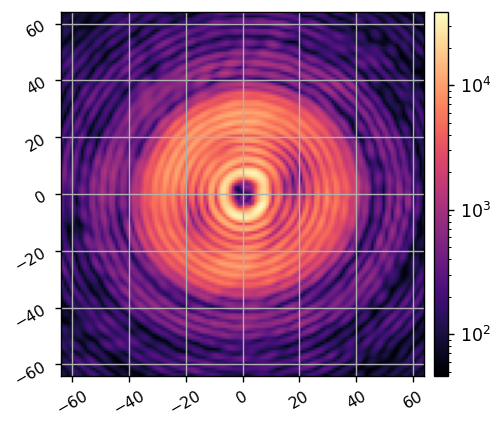

In [14]:
I.x_shift_locam = 0
I.y_shift_locam = 0
I.NLOCAM = 100

I.ref_locam_params = {
    'atten':5, 
    'texp':0.0001,
    'gain':100,
}
print(I.ref_locam_params)

I.return_ni_locam = True
I.subtract_dark_locam = False

ref_im = I.snap_locam()
imshow1(ref_im, grid=True, pxscl=1, lognorm=True)

In [4]:
locam_ref_0_channel = ImageStream('locam_ref_0')
locam_ref_delta_channel = ImageStream('locam_ref_delta')

# Perform LLOWFSC calibration

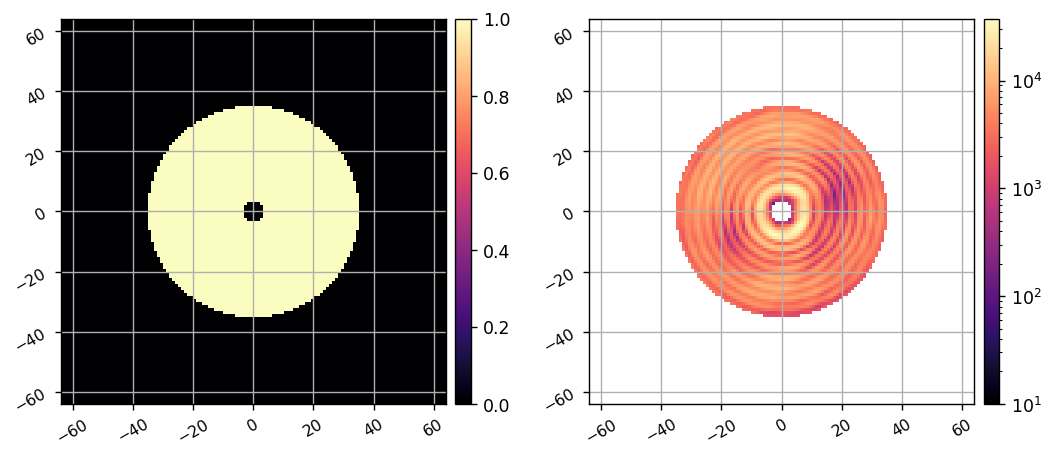

In [15]:
irad = 3
orad = 35
control_mask = ensure_np_array(lina.utils.create_annular_focal_plane_mask(I.nlocam, 1, irad, orad, edge=None, ))
# control_mask = xp.ones((M.nlocam, M.nlocam)).astype(bool)

ref_im = locam_ref_0_channel.grab_latest()
imshow2(control_mask, ref_im * control_mask, grid=True, pxscl=1, lognorm2=True, vmin2=1e1)

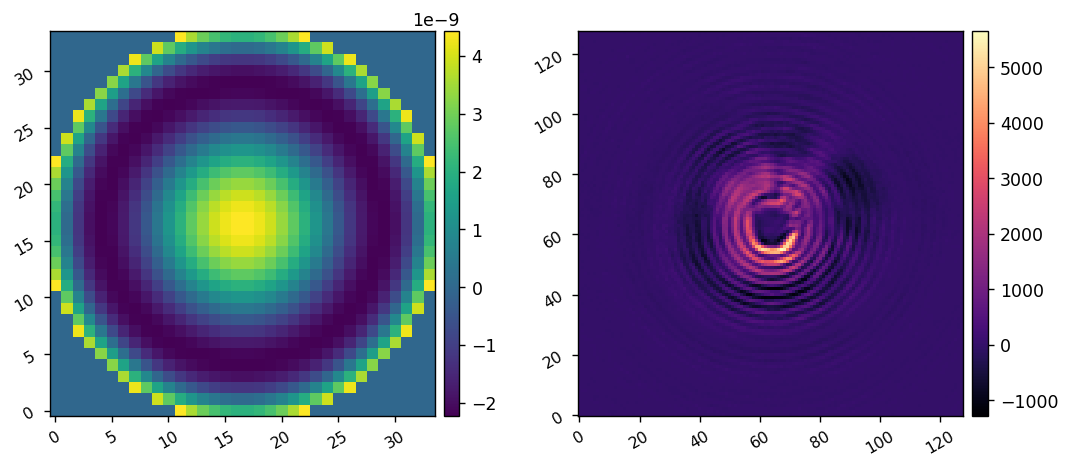

In [16]:
reload(lina.utils)
Nz_modes = 10
I.NLOCAM = 10
I.zero_dm()
zer_modes = ensure_np_array(lina.utils.create_zernike_modes(I.dm_mask, nmodes=Nz_modes, remove_modes=1))
zer_modal_matrix = zer_modes.reshape(Nz_modes, -1)

i = -1
amp = 2e-9
I.add_dm(amp*zer_modes[i])
locam_im = I.snap_locam()
imshow2(I.get_dm(), locam_im - locam_ref_0_channel.grab_latest(), cmap1='viridis')
I.zero_dm()

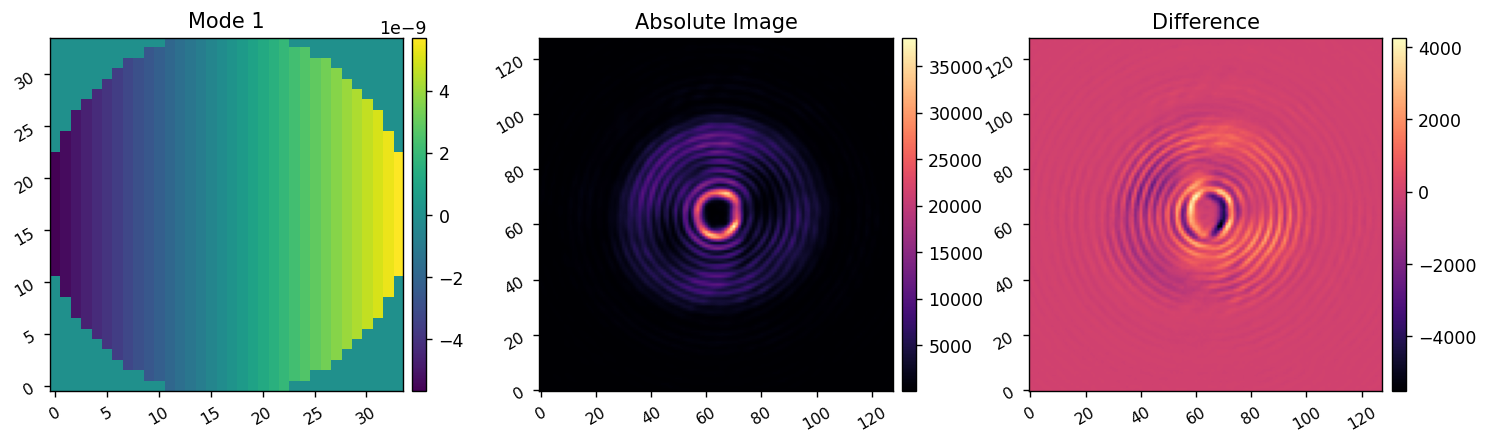

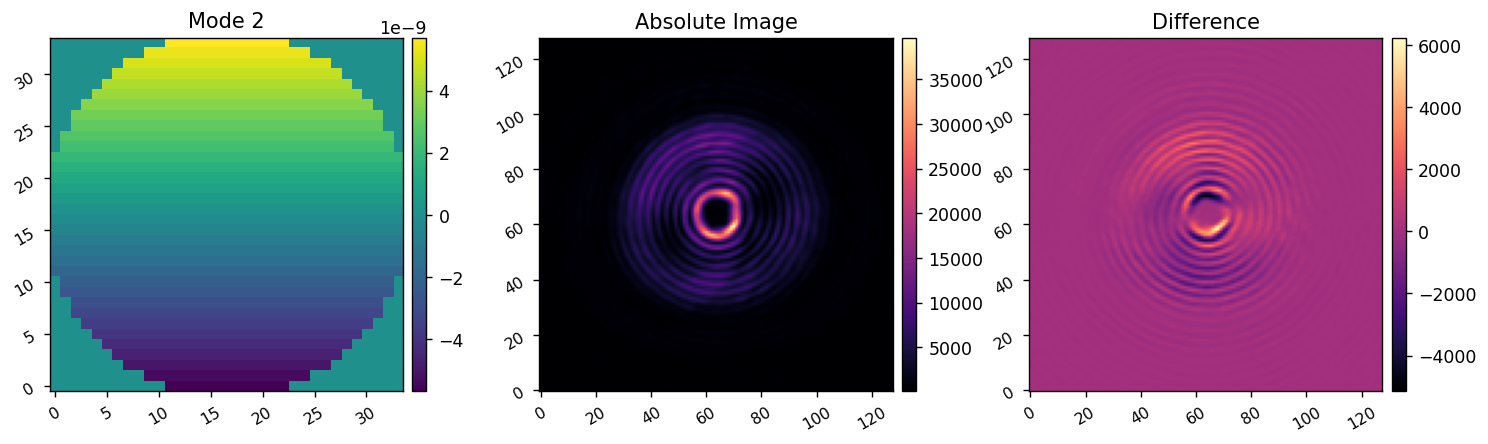

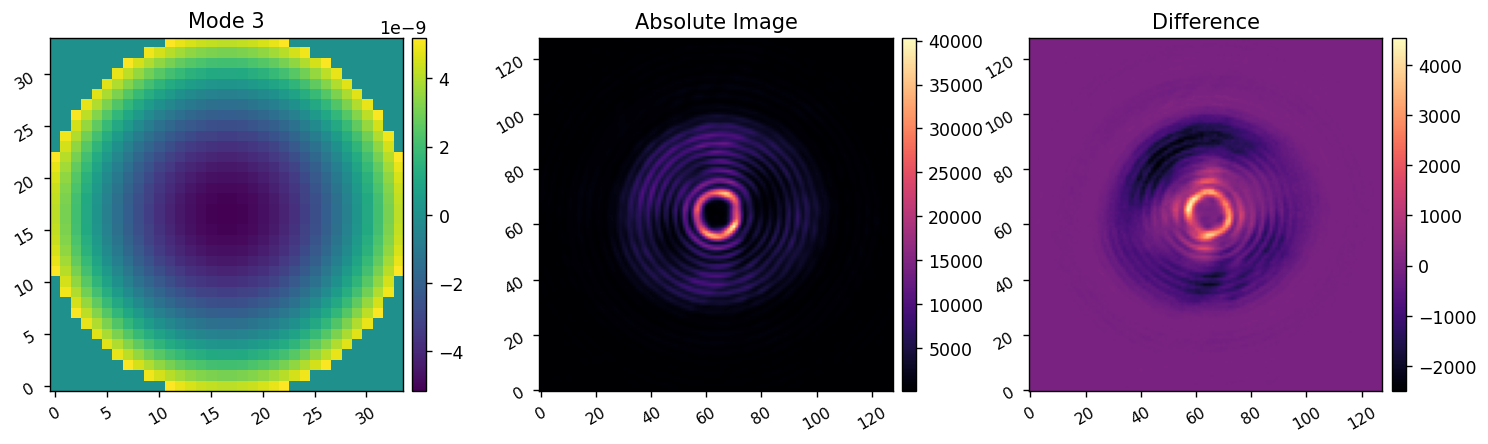

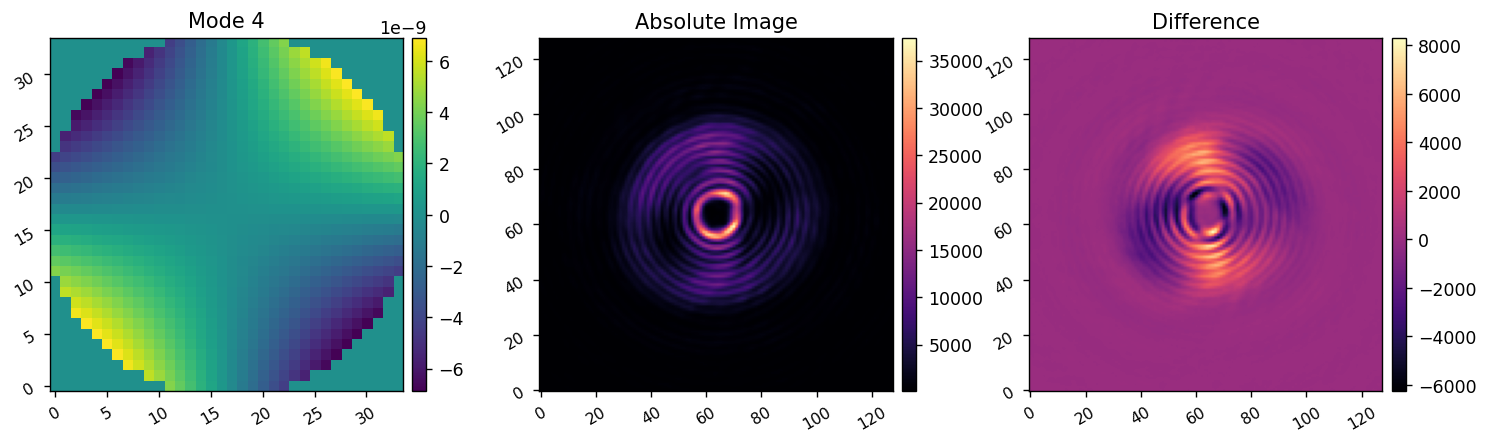

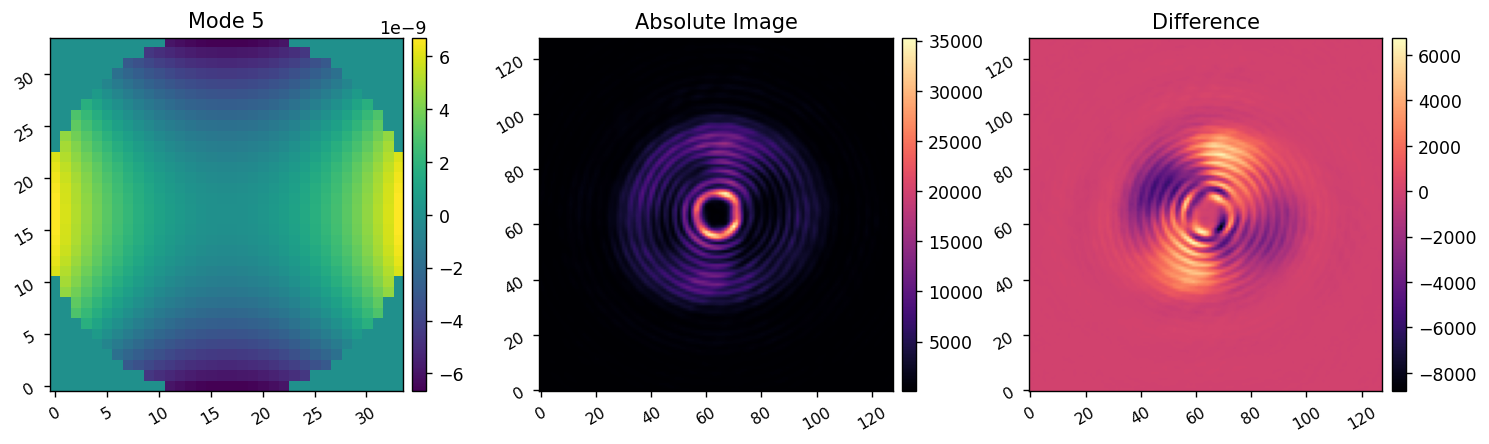

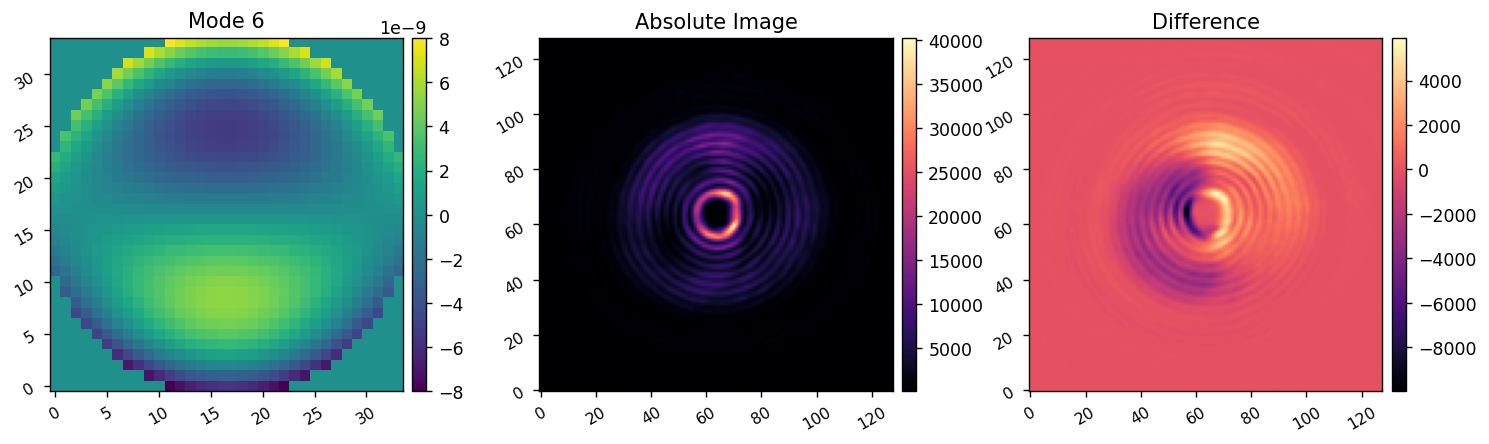

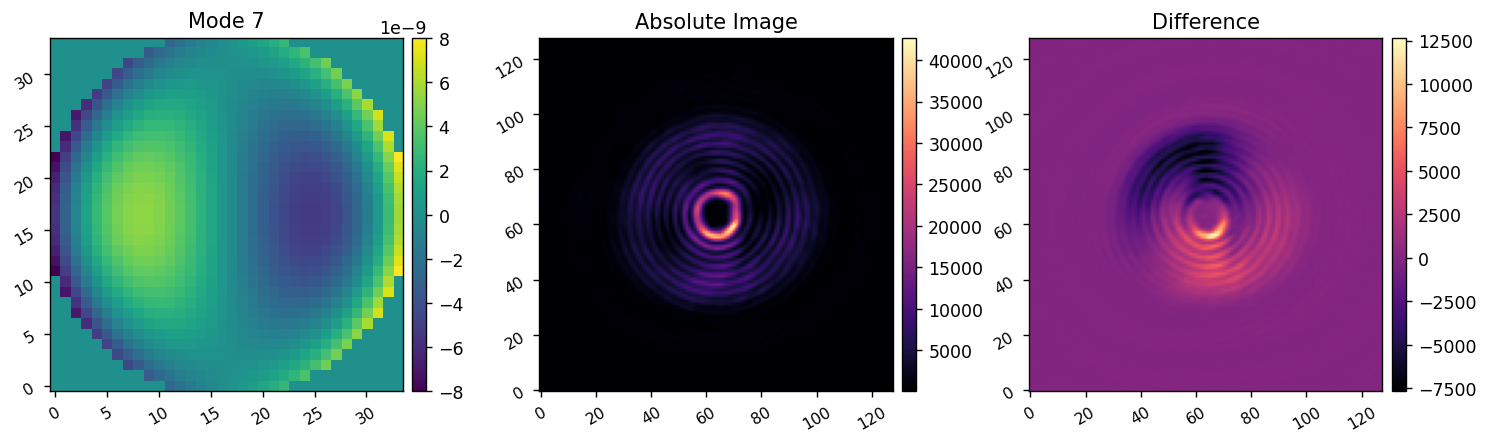

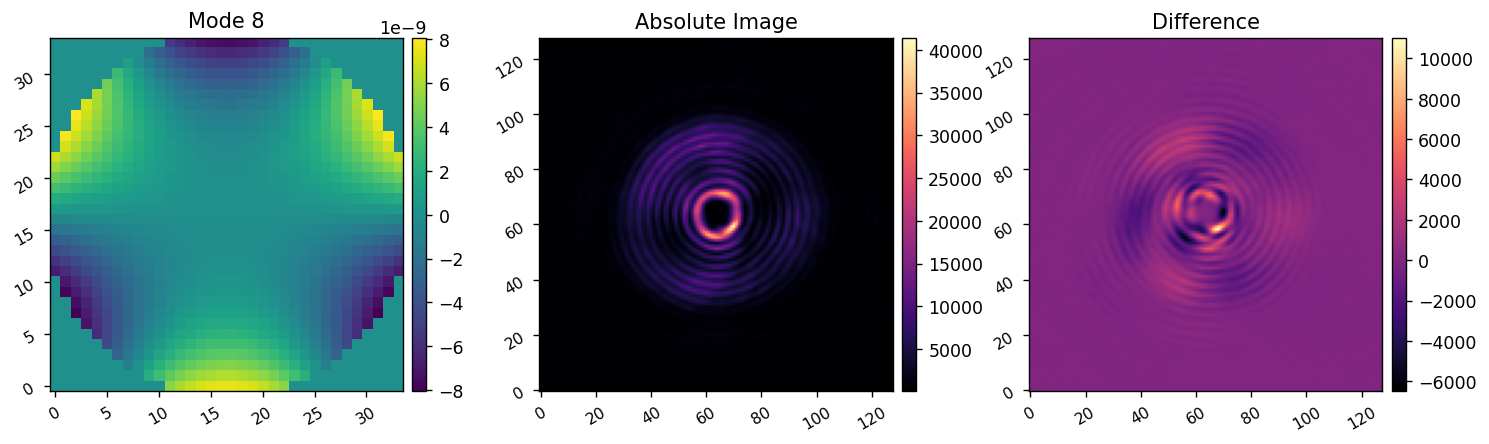

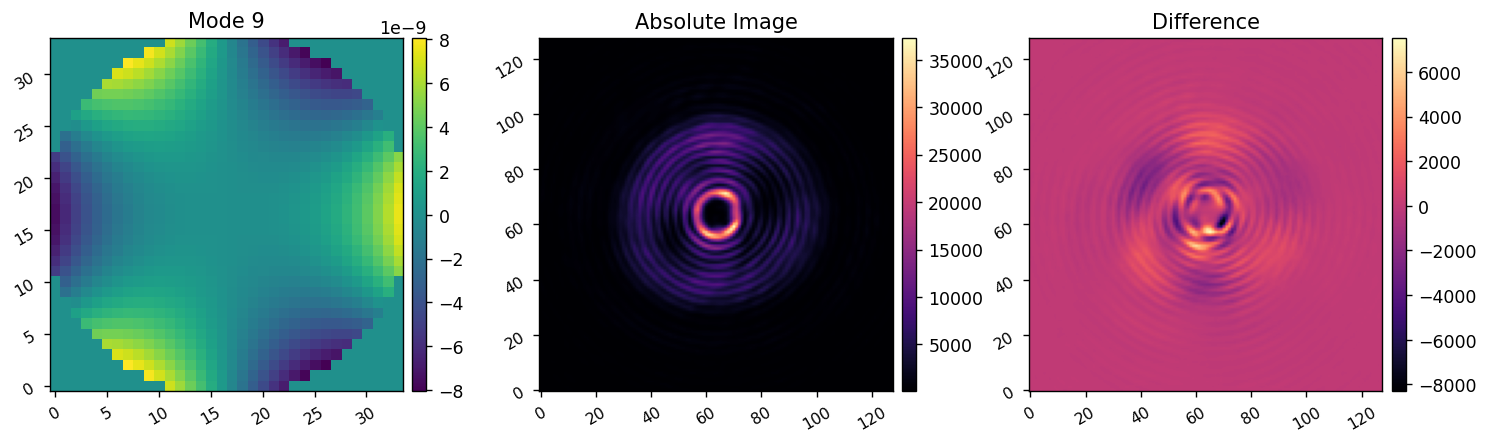

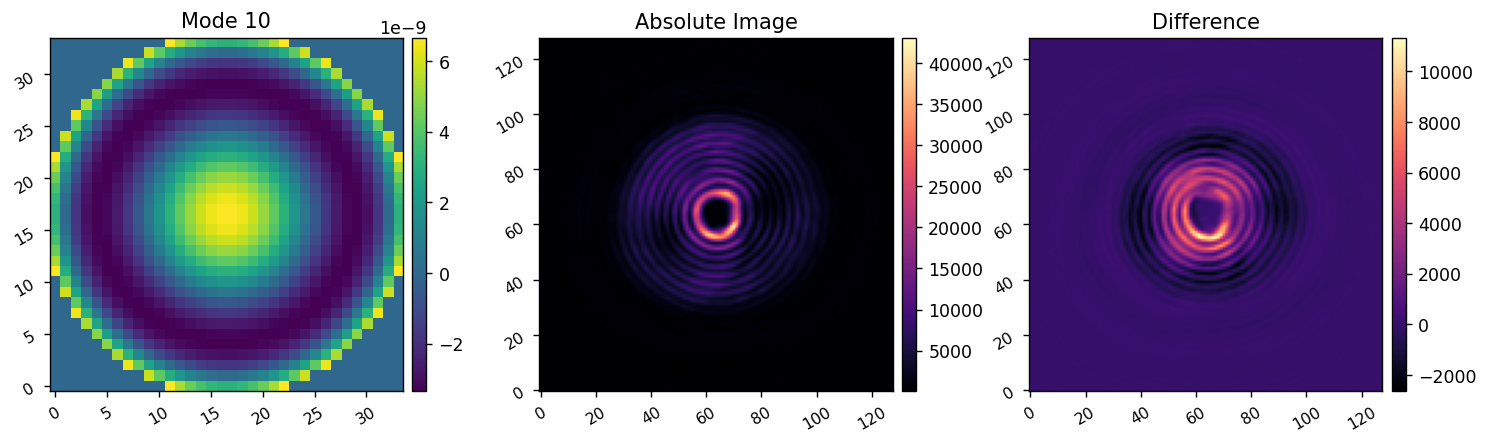

In [17]:
reload(lina.llowfsc)
I.zero_dm()
I.setattr('NLOCAM', 20)
zer_rm = lina.llowfsc.calibrate_without_fsm(
    I, 
    control_mask, 
    dm_modes=zer_modes, 
    amps=3e-9, 
    plot=True,
)

In [18]:
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

zer_calib_data = {
    'zer_response_matrix':zer_rm,
    'calib_amp':3e-9,
    'control_mask':control_mask,
    'NLOCAM':I.NLOCAM,
    'texp_locam':I.texp_locam,
    'gain_locam':I.gain_locam,
    'atten':I.atten,
}
utils.save_pickle(f'../data/llowfsc+iefc/{today}_llowfsc_zer_calib_data.pkl', zer_calib_data)

Saved data to:  ../data/llowfsc+iefc/20241216_llowfsc_zer_calib_data.pkl


In [19]:
cm = ensure_np_array(lina.utils.TikhonovInverse(xp.array(zer_rm), 0))

# Define the function and process to run LLOWFSC at the desired frequency

In [20]:
scoobi.create_shmim('llowfsc_gains', (Nz_modes, 1))

gains_channel = ImageStream('llowfsc_gains')

In [21]:
gains_channel.write(np.array([2*[0.5] + 8*[0.0],]))

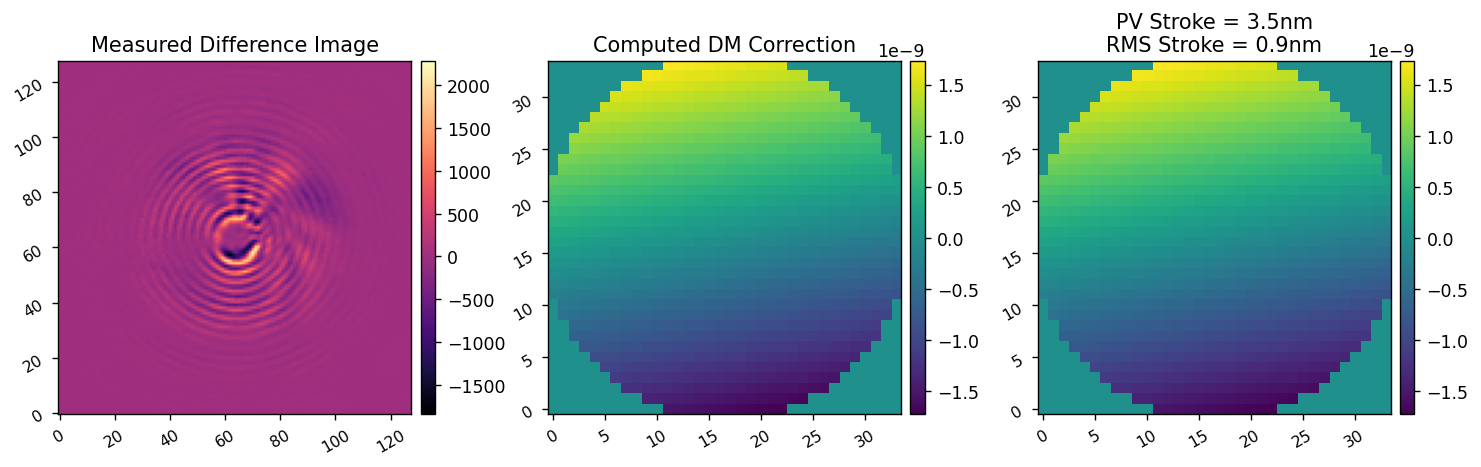

In [22]:
reload(lina.llowfsc)
I.return_ni_locam = True
lina.llowfsc.single_iteration(
    I, locam_ref_0_channel, locam_ref_delta_channel, gains_channel, cm, zer_modal_matrix, control_mask, 
    leakage=0.02,
    thresh=0, 
    plot=True
)
I.zero_dm()

# Define LLOWFSC process and start it

In [28]:
reload(scoobi)
reload(lina.llowfsc)
reload(lina.utils)

I.setattr('NLOCAM', 1)
llowfsc_freq = 25
I.return_ni_locam = True
I.dm_delay = 1*I.texp_locam

args = [
    I, 
    locam_ref_0_channel, 
    locam_ref_delta_channel, 
    gains_channel, 
    cm, 
    zer_modal_matrix, 
    control_mask,
]

kwargs = {
    'leakage':0.02, 
    # 'thresh':2*[1e-9] + 8*[0.25e-9],
}

llowfsc_process = lina.utils.Process(
    1/llowfsc_freq, 
    lina.llowfsc.single_iteration, 
    args, # the args
    kwargs, # the kwargs
)



In [29]:
llowfsc_process.start()

In [46]:
llowfsc_process.cancel()
I.zero_dm()

## Adjust gains

In [45]:
gains_channel.write(np.array([2*[0.5] + 8*[0.0]]))
gains_channel.write(np.array([2*[0.5] + 3*[0.1] + 5*[0.0]]))
gains_channel.write(np.array([2*[0.75] + 3*[0.25] + 5*[0.25]]))